In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

np.random.seed(1234)
_ = torch.manual_seed(123)

In [6]:
print(torch.__version__)

1.7.0


In [2]:
data = pd.read_csv('C:\\Users\\raibe\\Desktop\\Thesis Code\\datasets\\mortgage\\WideFormatMortgageAfterRemovingNull.csv')

In [3]:
data = data.drop(["id", "first_time", "payoff_time", "status_time", "time"], axis=1)

In [4]:
data.head()

,duration,orig_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time
0,24,-7,113,29087.21,26.658065,9.200,146.45,2.715903,8.3,0,0,1,0,45000.0,715,69.4,9.200,87.03,1
1,2,18,138,105654.77,65.469851,7.680,225.10,2.151365,4.7,0,0,1,0,107200.0,558,80.0,7.680,186.91,0
2,5,-6,114,44378.60,31.459735,11.375,217.37,1.692969,4.5,0,0,1,0,48600.0,680,83.6,8.750,89.58,0
3,36,-2,119,52686.35,34.898842,10.500,189.82,2.836358,5.7,0,0,1,0,63750.0,587,81.8,10.500,97.99,0
4,3,18,138,52100.71,66.346343,9.155,222.39,2.361722,4.4,0,0,1,0,52800.0,527,80.0,9.155,186.91,0


In [5]:
df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize = ['orig_time', 'mat_time', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 
                    'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']
cols_leave = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time']#, 'duration', 'default_time'


standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['duration'].values, df['default_time'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [6]:
in_features = x_train.shape[1]
num_nodes = [256, 256, 256, 256]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [7]:
model = CoxPH(net, tt.optim.Adam)

C:\Users\raibe\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


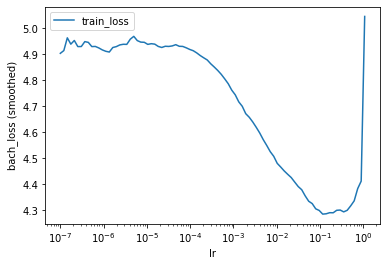

In [8]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [9]:
model.optimizer.set_lr(0.001)

In [10]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [11]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[1s / 1s],		train_loss: 3.6138,	val_loss: 3.2769
1:	[1s / 3s],		train_loss: 3.3221,	val_loss: 3.1735
2:	[2s / 6s],		train_loss: 3.2424,	val_loss: 3.0642
3:	[2s / 8s],		train_loss: 3.1690,	val_loss: 3.0183
4:	[2s / 10s],		train_loss: 3.1300,	val_loss: 2.9969
5:	[2s / 12s],		train_loss: 3.0887,	val_loss: 2.9814
6:	[2s / 15s],		train_loss: 3.0735,	val_loss: 2.9802
7:	[2s / 17s],		train_loss: 3.0360,	val_loss: 2.9320
8:	[2s / 20s],		train_loss: 3.0446,	val_loss: 2.9981
9:	[2s / 22s],		train_loss: 3.0044,	val_loss: 2.8997
10:	[2s / 25s],		train_loss: 2.9914,	val_loss: 2.9170
11:	[2s / 27s],		train_loss: 2.9682,	val_loss: 2.8927
12:	[2s / 29s],		train_loss: 2.9582,	val_loss: 2.8808
13:	[2s / 32s],		train_loss: 2.9660,	val_loss: 2.9202
14:	[2s / 35s],		train_loss: 2.9366,	val_loss: 2.9048
15:	[2s / 37s],		train_loss: 2.9346,	val_loss: 2.8858
16:	[2s / 40s],		train_loss: 2.9246,	val_loss: 2.8772
17:	[2s / 42s],		train_loss: 2.9052,	val_loss: 2.8775
18:	[2s / 45s],		train_loss: 2.8923,	val_l

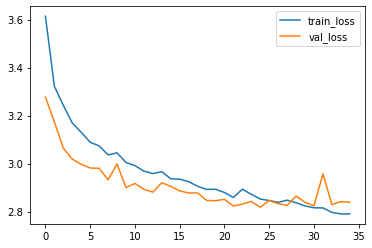

In [12]:
_ = log.plot()

In [13]:
model.partial_log_likelihood(*val).mean()

-6.6253057

In [14]:
_ = model.compute_baseline_hazards()

In [15]:
surv = model.predict_surv_df(x_test)

In [16]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [17]:
ev.concordance_td()

0.9134153866761866